[Understanding Why People Vote](https://ocw.mit.edu/courses/sloan-school-of-management/15-071-the-analytics-edge-spring-2017/trees/assignment-4/understanding-why-people-vote/)

# Understanding Why People Vote
#### In August 2006 three researchers (Alan Gerber and Donald Green of Yale University, and Christopher Larimer of the University of Northern Iowa) carried out a large scale field experiment in Michigan, USA to test the hypothesis that one of the reasons people vote is social, or extrinsic, pressure. To quote the first paragraph of their This resource may not render correctly in a screen reader.2008 research paper (PDF):
#### Among the most striking features of a democratic political system is the participation of millions of voters in elections. Why do large numbers of people vote, despite the fact that ... "the casting of a single vote is of no significance where there is a multitude of electors"? One hypothesis is adherence to social norms. Voting is widely regarded as a citizen duty, and citizens worry that others will think less of them if they fail to participate in elections. Voters' sense of civic duty has long been a leading explanation of vote turnout...
#### In this homework problem we will use both logistic regression and classification trees to analyze the data they collected.

# The Data
#### The researchers grouped about 344,000 voters into different groups randomly - about 191,000 voters were a "control" group, and the rest were categorized into one of four "treatment" groups. These five groups correspond to five binary variables in the dataset.
#### 1-"Civic Duty" (variable civicduty) group members were sent a letter that simply said "DO YOUR CIVIC DUTY — VOTE!"
#### 2-"Hawthorne Effect" (variable hawthorne) group members were sent a letter that had the "Civic Duty" message plus the additional message "YOU ARE BEING STUDIED" and they were informed that their voting behavior would be examined by means of public records.
#### 3-"Self" (variable self) group members received the "Civic Duty" message as well as the recent voting record of everyone in that household and a message stating that another message would be sent after the election with updated records.
#### 4-"Neighbors" (variable neighbors) group members were given the same message as that for the "Self" group, except the message not only had the household voting records but also that of neighbors - maximizing social pressure.
#### 5-"Control" (variable control) group members were not sent anything, and represented the typical voting situation.
#### Additional variables include sex (0 for male, 1 for female), yob (year of birth), and the dependent variable voting (1 if they voted, 0 otherwise).

# Problem 1.1 - Exploration and Logistic Regression

#### We will first get familiar with the data. Load the CSV file gerber (CSV - 6.2MB) into R. What proportion of people in this dataset voted in this election?

In [1]:
data  <- read.csv("../data/gerber.csv")
str(data)
sum(data$voting) / nrow(data)

'data.frame':	344084 obs. of  8 variables:
 $ sex      : int  0 1 1 1 0 1 0 0 1 0 ...
 $ yob      : int  1941 1947 1982 1950 1951 1959 1956 1981 1968 1967 ...
 $ voting   : int  0 0 1 1 1 1 1 0 0 0 ...
 $ hawthorne: int  0 0 1 1 1 0 0 0 0 0 ...
 $ civicduty: int  1 1 0 0 0 0 0 0 0 0 ...
 $ neighbors: int  0 0 0 0 0 0 0 0 0 0 ...
 $ self     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ control  : int  0 0 0 0 0 1 1 1 1 1 ...


[1] 0.3158996

# Problem 1.2 - Exploration and Logistic Regression
#### Which of the four "treatment groups" had the largest percentage of people who actually voted (voting = 1)?
- <font color='red'>Civic Duty</font><br>
- <font color='red'>Hawthorne Effect</font><br>
- <font color='red'>Self</font><br>
- <font color='red'>Neighbors</font><br>

In [2]:
set = subset(data, voting == 1)
which.max(c(
    (table(set$voting, set$hawthorne) / nrow(set))[,2],
    (table(set$voting, set$civicduty) / nrow(set))[,2],
    (table(set$voting, set$self) / nrow(set))[,2],
    (table(set$voting, set$neighbors) / nrow(set))[,2]
))

[1] 4

# Problem 1.3 - Exploration and Logistic Regression
#### Build a logistic regression model for voting using the four treatment group variables as the independent variables (civicduty, hawthorne, self, and neighbors). Use all the data to build the model (DO NOT split the data into a training set and testing set). Which of the following coefficients are significant in the logistic regression model? Select all that apply.
- <font color='red'>Civic Duty</font> # Correct <br>
- <font color='red'>Hawthorne Effect</font> # Correct <br>
- <font color='red'>Self</font> # Correct <br>
- <font color='red'>Neighbors</font> # Correct <br>

In [3]:
modelLog <- glm(voting ~ hawthorne + civicduty + self + neighbors, 
                data = data, family = binomial)
df = as.data.frame(summary(modelLog)$coefficients)
# sort coefficients and take variables names that saticify distinct threshold.
df_sorted <- df[order(df["Pr(>|z|)"]),]
row.names(subset(df, df[,4] < 0.05))

[1] "(Intercept)" "hawthorne"   "civicduty"   "self"        "neighbors"

# Problem 1.4 - Exploration and Logistic Regression
#### Using a threshold of 0.3, what is the accuracy of the logistic regression model? (When making predictions, you don't need to use the newdata argument since we didn't split our data.)

In [4]:
library(caTools)
prdictionLog <- predict(modelLog, type = "response")

In [5]:
a = table(data$voting, prdictionLog > 0.3)
(a[1,1] + a[2,2]) / sum(a)

[1] 0.5419578

# Problem 1.5 - Exploration and Logistic Regression
#### Using a threshold of 0.5, what is the accuracy of the logistic regression model?

In [6]:
a = table(data$voting, prdictionLog > 0.5)
a[1] / sum(a)

[1] 0.6841004

# Problem 1.6 - Exploration and Logistic Regression
#### Compare your previous two answers to the percentage of people who did not vote (the baseline accuracy) and compute the AUC of the model. What is happening here?
- <font color='red'>Even though all of the variables are significant, this is a weak predictive model.</font> # Correct <br>
- <font color='red'>The model's accuracy doesn't improve over the baseline, but the AUC is high, so this is a strong predictive model.</font><br>

In [7]:
a  <- table(data$voting)
a[1] / sum(a)

0 
0.6841004

# Problem 2.1 - Trees
#### We will now try out trees. Build a CART tree for voting using all data and the same four treatment variables we used before. Don't set the option method="class" - we are actually going to create a regression tree here. We are interested in building a tree to explore the fraction of people who vote, or the probability of voting. We’d like CART to split our groups if they have different probabilities of voting. If we used method=‘class’, CART would only split if one of the groups had a probability of voting above 50\% and the other had a probability of voting less than 50\% (since the predicted outcomes would be different). However, with regression trees, CART will split even if both groups have probability less than 50\%.
#### Leave all the parameters at their default values. You can use the following command in R to build the tree:
#### CARTmodel = rpart(voting ~ civicduty + hawthorne + self + neighbors, data=gerber)
#### Plot the tree. What happens, and if relevant, why?
- <font color='red'>Only the "Neighbors" variable is used in the tree - it is the only one with a big enough effect.</font><br>
- <font color='red'>All variables are used - they all make a difference.</font><br>
- <font color='red'>No variables are used (the tree is only a root node) - none of the variables make a big enough effect to be split on.</font> # Correct <br>

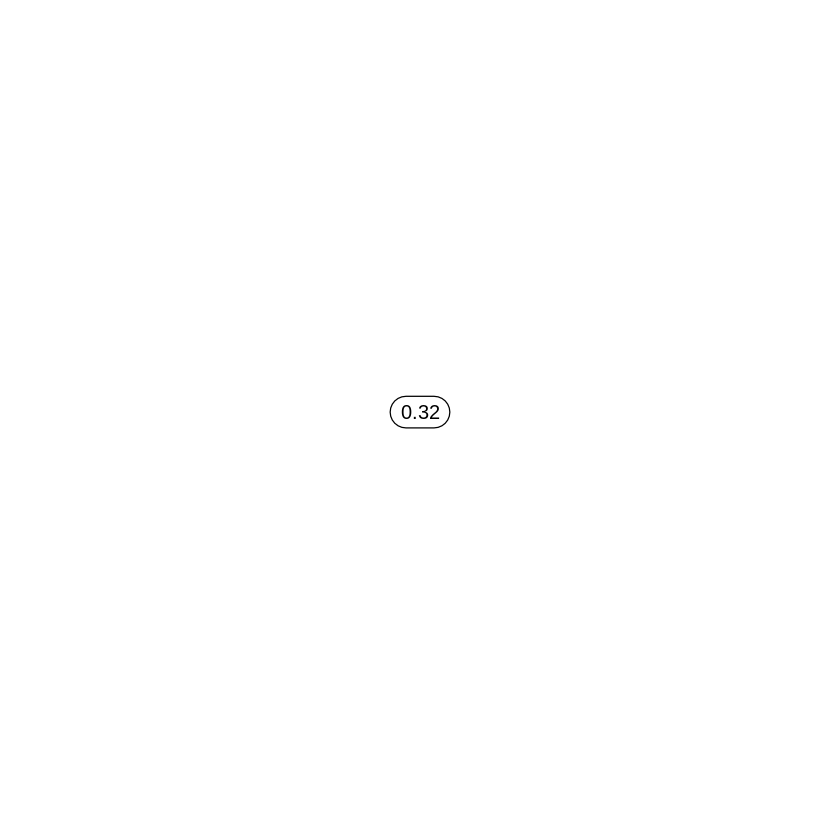

In [8]:
library(rpart)
library(rpart.plot)
CARTmodel = rpart(voting ~ civicduty + hawthorne + self + neighbors, data=data)
prp(CARTmodel)

# Problem 2.2 - Trees
#### Now build the tree using the command:
#### CARTmodel2 = rpart(voting ~ civicduty + hawthorne + self + neighbors, data=gerber, cp=0.0)
#### to force the complete tree to be built. Then plot the tree. What do you observe about the order of the splits?
- <font color='red'>Civic duty is the first split, neighbor is the last.</font><br>
- <font color='red'>Neighbor is the first split, civic duty is the last.</font> # Correct <br>

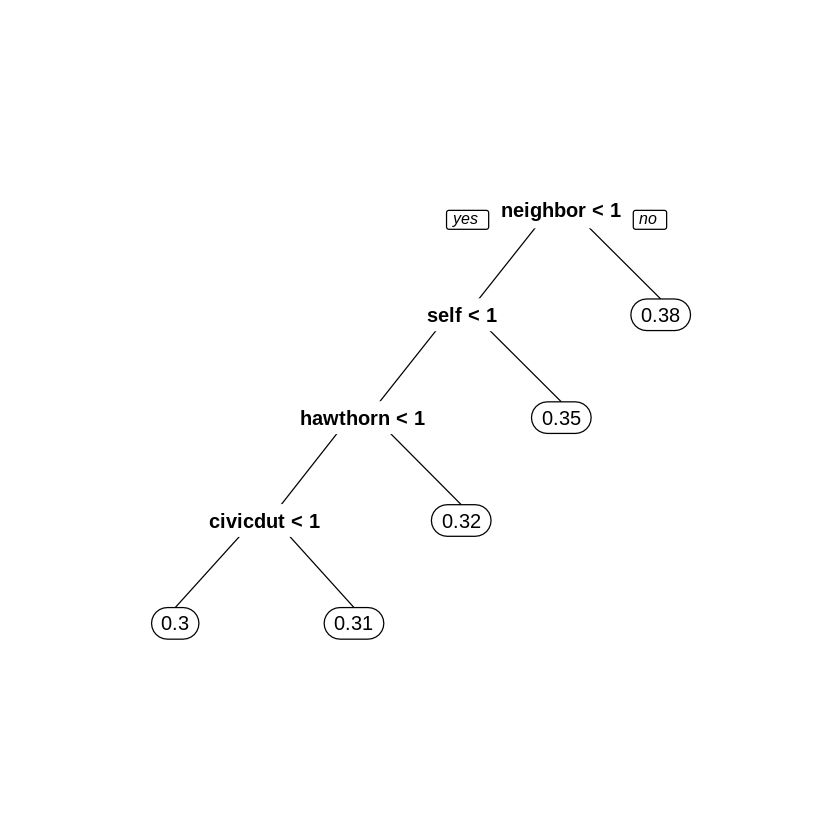

In [9]:
CARTmodel2 = rpart(voting ~ civicduty + hawthorne + self + neighbors, data=data, cp=0.0)
prp(CARTmodel2)

# Problem 2.3 - Trees
#### Using only the CART tree plot, determine what fraction (a number between 0 and 1) of "Civic Duty" people voted:

In [10]:
0.31 # in Tree; Yes always on left

[1] 0.31

# Problem 2.4 - Trees
#### Make a new tree that includes the "sex" variable, again with cp = 0.0. Notice that sex appears as a split that is of secondary importance to the treatment group.
#### In the control group, which gender is more likely to vote?
- <font color='red'>Men (0)</font> # Correct <br>
- <font color='red'>Women (1)</font><br>

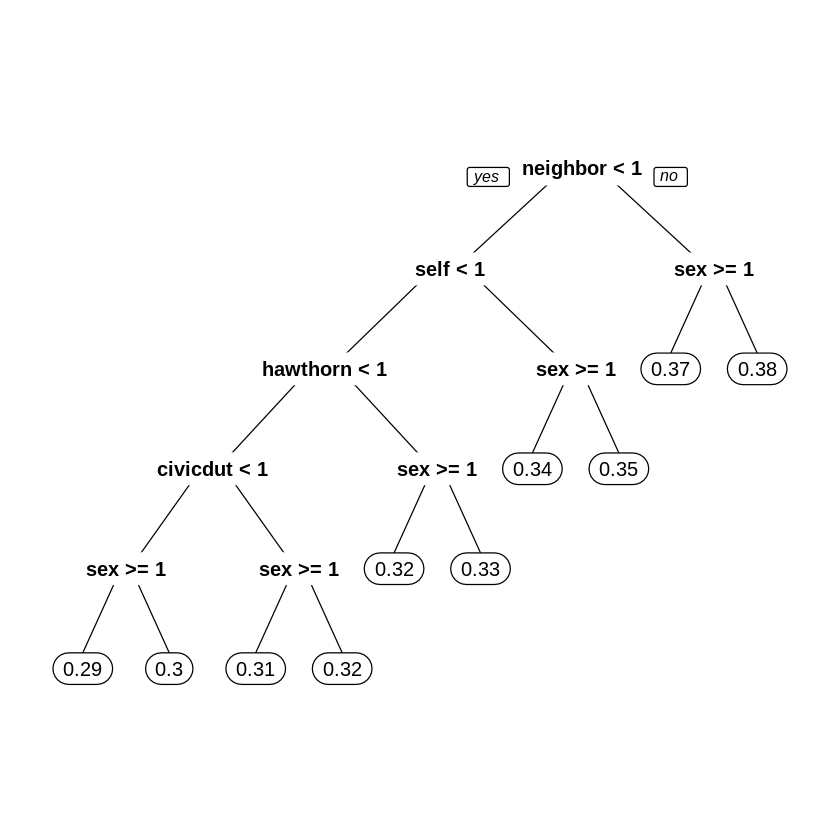

In [11]:
modelTree  <- rpart(voting ~ civicduty + hawthorne + self + neighbors + sex, data=data, cp=0.0)
prp(modelTree)

#### In the "Civic Duty" group, which gender is more likely to vote?
- <font color='red'>Men (0)</font> # Correct <br>
- <font color='red'>Women (1)</font><br>

# Problem 3.1 - Interaction Terms
#### We know trees can handle "nonlinear" relationships, e.g. "in the 'Civic Duty' group and female", but as we will see in the next few questions, it is possible to do the same for logistic regression. First, let's explore what trees can tell us some more.
#### Let's just focus on the "Control" treatment group. Create a regression tree using just the "control" variable, then create another tree with the "control" and "sex" variables, both with cp=0.0.
#### In the "control" only tree, what is the absolute value of the difference in the predicted probability of voting between being in the control group versus being in a different group? You can use the absolute value function to get answer, i.e. abs(Control Prediction - Non-Control Prediction). Add the argument "digits = 6" to the prp command to get a more accurate estimate.

[1] 0.043362

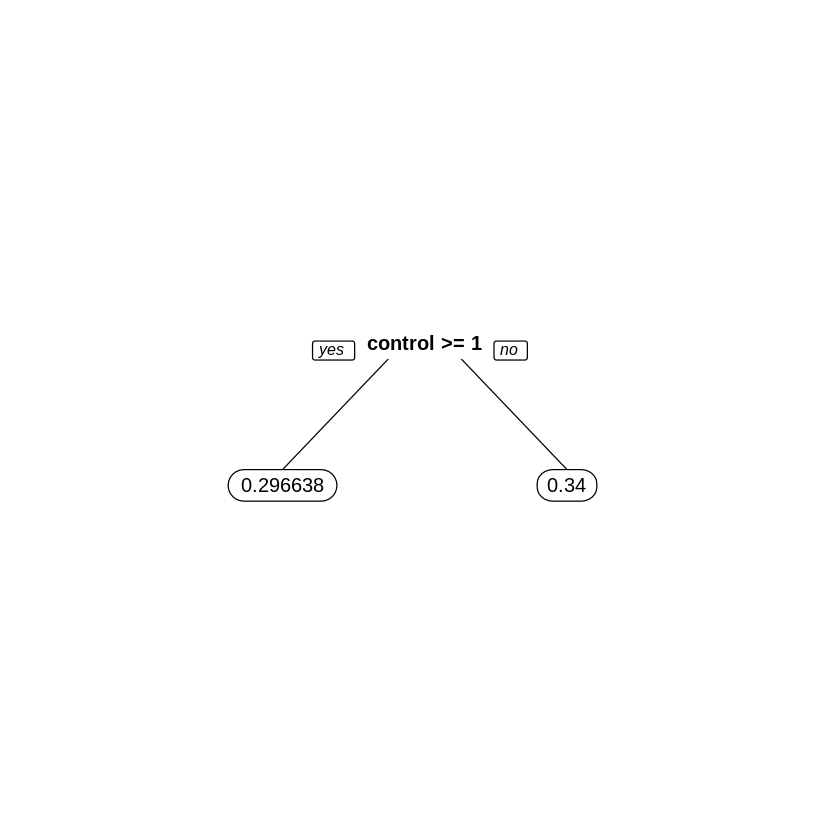

In [12]:
controlOnly <- rpart(voting ~ control,data=data, cp=0.0)
prp(controlOnly, digits = 6)
abs(0.296638-0.34)

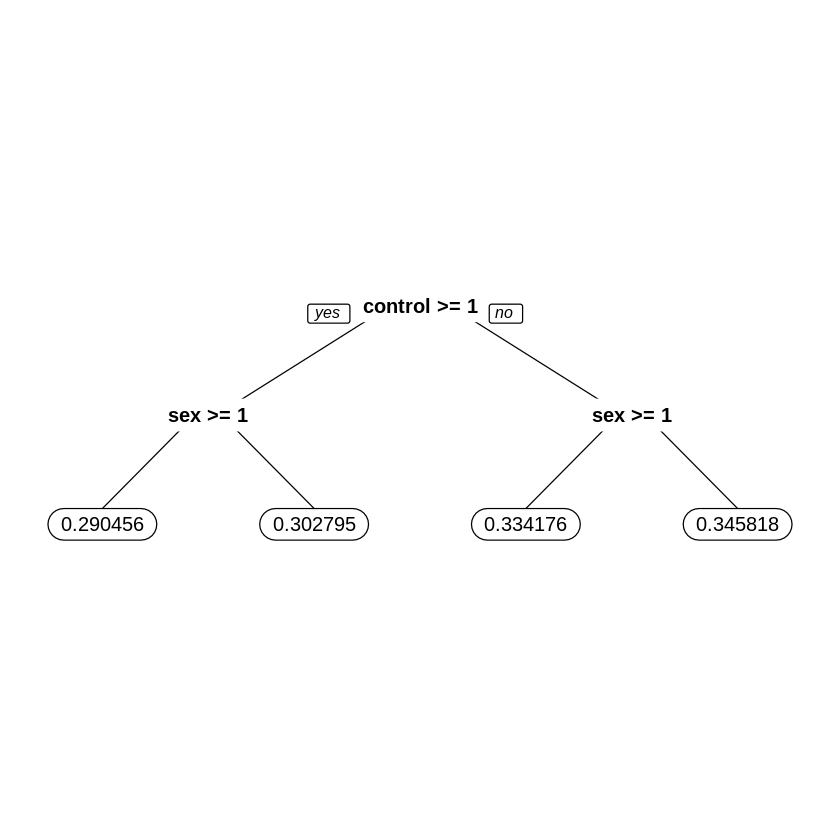

In [13]:
controlANDsex <- rpart(voting ~ sex + control, data=data, cp=0.0)
prp(controlANDsex, digits = 6)

# Problem 3.2 - Interaction Terms
#### Now, using the second tree (with control and sex), determine who is affected more by NOT being in the control group (being in any of the four treatment groups):
- <font color='red'>Men, by a margin of more than 0.001</font><br>
- <font color='red'>Women, by a margin of more than 0.001</font><br>
- <font color='red'>They are affected about the same (change in probability within 0.001 of each other).</font> # Correct <br>

# Problem 3.3 - Interaction Terms
#### Going back to logistic regression now, create a model using "sex" and "control". Interpret the coefficient for "sex":
- <font color='red'>Coefficient is negative, reflecting that women are less likely to vote</font> # Correct # man=0, by nagative coefficients we more likely predict 0 which is man, so women is less likely to vote<br>
- <font color='red'>Coefficient is negative, reflecting that women are more likely to vote</font><br>
- <font color='red'>Coefficient is positive, reflecting that women are less likely to vote</font><br>
- <font color='red'>Coefficient is positive, reflecting that women are more likely to vote</font><br>

In [14]:
modelLog2 <- glm(voting ~ control + sex, data = data, family = binomial)
summary(modelLog2)


Call:
glm(formula = voting ~ control + sex, family = binomial, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9220  -0.9012  -0.8290   1.4564   1.5717  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.635538   0.006511 -97.616  < 2e-16 ***
control     -0.200142   0.007364 -27.179  < 2e-16 ***
sex         -0.055791   0.007343  -7.597 3.02e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 429238  on 344083  degrees of freedom
Residual deviance: 428443  on 344081  degrees of freedom
AIC: 428449

Number of Fisher Scoring iterations: 4


# Problem 3.4 - Interaction Terms
#### The regression tree calculated the percentage voting exactly for every one of the four possibilities (Man, Not Control), (Man, Control), (Woman, Not Control), (Woman, Control). Logistic regression has attempted to do the same, although it wasn't able to do as well because it can't consider exactly the joint possibility of being a women and in the control group.
#### We can quantify this precisely. Create the following dataframe (this contains all of the possible values of sex and control), and evaluate your logistic regression using the predict function (where "LogModelSex" is the name of your logistic regression model that uses both control and sex):
#### Possibilities = data.frame(sex=c(0,0,1,1),control=c(0,1,0,1)) <br> predict(LogModelSex, newdata=Possibilities, type="response")
#### The four values in the results correspond to the four possibilities in the order they are stated above ( (Man, Not Control), (Man, Control), (Woman, Not Control), (Woman, Control) ). What is the absolute difference between the tree and the logistic regression for the (Woman, Control) case? Give an answer with five numbers after the decimal point.

In [15]:
Possibilities = data.frame(sex=c(0,0,1,1),control=c(0,1,0,1)) 
predict(modelLog2, newdata=Possibilities, type="response")
abs(0.290806452511953 - 0.290456) # sex=1 and control=1. the last row of Possibilities saticifay this, so we pick the last row returned by (predict ....))

1         2         3         4 
0.3462559 0.3024455 0.3337375 0.2908065

[1] 0.0003504525

# Problem 3.5 - Interaction Terms
#### So the difference is not too big for this dataset, but it is there. We're going to add a new term to our logistic regression now, that is the combination of the "sex" and "control" variables - so if this new variable is 1, that means the person is a woman AND in the control group. We can do that with the following command:
#### LogModel2 = glm(voting ~ sex + control + sex:control, data=gerber, family="binomial")
#### How do you interpret the coefficient for the new variable in isolation? That is, how does it relate to the dependent variable?
- <font color='red'>If a person is a woman or in the control group, the chance that she voted goes up.</font><br>
- <font color='red'>If a person is a woman and in the control group, the chance that she voted goes up.</font><br>
- <font color='red'>If a person is a woman or in the control group, the chance that she voted goes down.</font><br>
- <font color='red'>If a person is a woman and in the control group, the chance that she voted goes down.</font> # correct<br>

In [16]:
LogModel2 = glm(voting ~ sex + control + sex:control, data=data, family="binomial")
summary(LogModel2)


Call:
glm(formula = voting ~ sex + control + sex:control, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9213  -0.9019  -0.8284   1.4573   1.5724  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.637471   0.007603 -83.843  < 2e-16 ***
sex         -0.051888   0.010801  -4.804 1.55e-06 ***
control     -0.196553   0.010356 -18.980  < 2e-16 ***
sex:control -0.007259   0.014729  -0.493    0.622    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 429238  on 344083  degrees of freedom
Residual deviance: 428442  on 344080  degrees of freedom
AIC: 428450

Number of Fisher Scoring iterations: 4


# Problem 3.6 - Interaction Terms
#### Run the same code as before to calculate the average for each group:
#### predict(LogModel2, newdata=Possibilities, type="response")
#### Now what is the difference between the logistic regression model and the CART model for the (Woman, Control) case? Again, give your answer with five numbers after the decimal point.

In [17]:
predict(LogModel2, newdata=Possibilities, type="response")
abs(0.29045577924766 - 0.290456)

1         2         3         4 
0.3458183 0.3027947 0.3341757 0.2904558

[1] 2.207523e-07

# Problem 3.7 - Interaction Terms
#### This example has shown that trees can capture nonlinear relationships that logistic regression can not, but that we can get around this sometimes by using variables that are the combination of two variables. Should we always include all possible interaction terms of the independent variables when building a logistic regression model?
- <font color='red'>Yes</font><br>
- <font color='red'>No</font> # Correct <br>